# Linear Models on for TF binding

In [2]:
libs <- c(
    'RColorBrewer',
    'ggplot2',
    'xgboost',
    'glmnet',
    'dplyr',
    'tidyr',
    'pROC',
    'stringr',
    'caret'
)

for (lib in libs) {
        if (!require(lib, character.only = TRUE, quietly = TRUE)) {
            install.packages(lib, repos='http://cran.us.r-project.org')
        }
}

(.packages())

[1] "caret"        "lattice"      "stringr"      "pROC"         "tidyr"       
 [6] "dplyr"        "glmnet"       "foreach"      "Matrix"       "xgboost"     
[11] "ggplot2"      "RColorBrewer" "stats"        "graphics"     "grDevices"   
[16] "utils"        "datasets"     "methods"      "base"

## load utility functions

In [3]:
split_data <- function(outcomes,p=0.75) {
    n <- length(outcomes)
    s <- floor(p*n)
    sample_inds <- sample(seq_len(n), size = s)
    return(sample_inds)
}

In [4]:
mattcc <- function(true_classes, predicted_classes) {
        
    pos <- true_classes == 1
    neg <- true_classes == 0
    
    TP <- as.numeric(sum( predicted_classes[pos] == true_classes[pos] ))
    TN <- as.numeric(sum( predicted_classes[neg] == true_classes[neg] ))
    FP <- as.numeric(sum( predicted_classes[pos] != true_classes[pos] ))
    FN <- as.numeric(sum( predicted_classes[neg] != true_classes[neg] )) 
    
    N1 <- TP*TN
    N2 <- FP*FN
    D1 <- TP+FP
    D2 <- TP+FN
    D3 <- TN+FP
    D4 <- TN+FN
    
    N <- N1-N2
    D <- D1*D2*D3*D4
    
    if (D==0) {
        M <- 0
    } else {
        M <- N/sqrt(D)
    }
    
    return(M)
}

mattcc.curve <- function(true.values, pred.probs, num.points=101) {
    threshholds <- seq(from=0, to=1, length.out=num.points)
    thresh.inds <- 1:length(threshholds)

    mattcc.data <- sapply(thresh.inds,
                      function(t) mattcc(true.values,as.numeric(pred.probs>threshholds[t]))
                   )
    return(mattcc.data)
}

In [5]:
ggplotColours <- function(n = 6, h = c(0, 360) + 15){
  if ((diff(h) %% 360) < 1) h[2] <- h[2] - 360/n
  hcl(h = (seq(h[1], h[2], length = n)), c = 100, l = 65)
} 

## load data

In [11]:
# paul's data frame

# tableName <- "ftClean.Fri.Sep.30.2016-18:02:21.RData"
tableName <- "chr19.all.RData"
directory <- "~/git-repos/BDDS/trenadb/featureTable/lymphoblast"
fullPath <- file.path(directory, tableName)
stopifnot(file.exists(fullPath))
load(fullPath)
ft.clean <- tbl
dim(ft.clean)

# cory's motif to tf-class mapping
tf.fams.file <- "/local/Cory/for_Paul/motif_class_fam"
tf.fams.table <- read.delim(tf.fams.file, stringsAsFactors=FALSE)

# mapping from tf names to motif names
tf.motif.table <- read.csv("/local/sament/tfbs/human_brain/motif_to_tf_mappings_with_tfclass.csv")
named.motifs <- tf.motif.table$motif
names(named.motifs) <- tf.motif.table$tfs

[1] 1145089      11

## add TF classes to dataframe

In [13]:
# check overlap of motif names from cory and paul
motif.names.from.cory <- str_replace_all(string=tf.fams.table$ID, pattern="[[:space:]]", repl="")
motif.names.from.paul <- unique(ft.clean$motif)

# motifs that i'll use
from.paul.in.cory <- sort(motif.names.from.paul[(motif.names.from.paul %in% motif.names.from.cory)])

# filter out the motifs in pauls' table that cory doesn' have tf classes for
ft.clean.corymotifs <- ft.clean %>% filter(motif %in% from.paul.in.cory)

In [14]:
# find unique tf class names from cory's list
class.names.nospaces <- str_replace_all(string=tf.fams.table$class, pattern="[[:space:]]", repl="")
unique.class.names.nospaces <- unique(class.names.nospaces)
double.entry.classes <- grep('::', unique.class.names.nospaces, value=TRUE)
dedoubled.classes <- unique(unlist(strsplit(double.entry.classes,'::')))

class.names.nospaces.minus.doubles <- unique.class.names.nospaces[!(unique.class.names.nospaces %in% double.entry.classes)]
class.names.final <- sort(unique(c(class.names.nospaces.minus.doubles,dedoubled.classes)))


# cory's map: arange so grepping on class column will yeild matches from paul's names
tf.fams.table.renamed <- tf.fams.table
tf.fams.table.renamed$ID <- str_replace_all(string=tf.fams.table.renamed$ID, pattern="[[:space:]]", repl="")
tf.fams.table.renamed <- tf.fams.table.renamed %>% filter(ID %in% from.paul.in.cory)
rownames(tf.fams.table.renamed) <- tf.fams.table.renamed$ID
tf.class.foreach.motif <- tf.fams.table.renamed[,-c(1)]

tf.class.foreach.motif$class <- str_replace_all(string=tf.class.foreach.motif$class, pattern="[[:space:]]", repl="")


# make sparse class / tf feature matrix map
# all zeros to start, fill in ones below
tf.motif.class.matrix <- matrix(0L, nrow = length(from.paul.in.cory), ncol = length(class.names.final))
rownames(tf.motif.class.matrix) <- from.paul.in.cory
colnames(tf.motif.class.matrix) <- class.names.final

# loop through tfs and classes to fill in ones where there is a match
for (tf.name in rownames(tf.motif.class.matrix)) {
    for (class.name in colnames(tf.motif.class.matrix)) {
        class.to.check <- tf.class.foreach.motif[tf.name,'class']
        classes.match <- any(grep(class.name, class.to.check, value=FALSE, fixed=TRUE))
        if (classes.match == 1) {
            tf.motif.class.matrix[tf.name,class.name] <- 1
        }
    }
    
}

In [15]:
# merge in class info to paul's data frame
tf.motif.class.df <- as.data.frame(tf.motif.class.matrix)
tf.motif.class.df$motif <- rownames(tf.motif.class.df)

ft.clean.corymotifs.tfclasses <- merge(ft.clean.corymotifs, tf.motif.class.df, by="motif", all.x=TRUE)
dim(ft.clean.corymotifs.tfclasses)

[1] 912159     41

## linear models for each regressor and all in total

In [16]:
# generate a dataframe of statistics one motif for the different linear models

make.stats.df <- function(tf.string, ft.data) {

    df.motif <- data.frame()
    
    # if motif !- all, subset to just that motif
    if (tf.string == "all") {
        ft.motif.subset <- ft.data
    } else {
        # select inds for just this motif
        motif.string <- named.motifs[tf.string]
        TF.inds <- ft.data$motif == motif.string
        ft.motif.subset <- ft.data[TF.inds,]
    }
    
    # check to make sure we have data
    if (dim(ft.motif.subset)[2] == 0) {
        stop("no instances of a motif for this TF")
    }
    
    # binarize chipseq score
    y.tf <- as.numeric(ft.motif.subset$csscore > 0)
    
    # check to make sure we have instances of both classes
    if (sum(y.tf == 0) == 0) {
        stop("no negative instances for this TF")
    }
    
    # check to make sure we have instances of both classes
    if (sum(y.tf == 1) == 0) {
        stop("no positive or instances for this TF")
    }
    
    # drop all class info
    X.tf <- ft.motif.subset[,c(1:11)]

    # drop some more columns 
    cols.to.drop <- c("csscore", "csTF", "motif", "loc", "totalsamplecount")
    X.tf <- X.tf[,!(colnames(X.tf) %in% cols.to.drop)]

    # split into test and train sets
    train.inds.tf <- split_data(y.tf)

    df.tf <- cbind("CHIPseq.bound"=y.tf,X.tf)
    df.tf.train <- df.tf[train.inds.tf,]
    df.tf.test <- df.tf[-train.inds.tf,]

    # for all regressors together, make a model and plot a roc curve
    boilerplate <- "CHIPseq.bound ~ "
    regressors <- colnames(X.tf)

    all.regressors <- paste(regressors, collapse=" + ")
    formula.text.all <- paste(boilerplate, all.regressors, sep="")

    # make a linear model using the training data
    glm.tf <- glm(as.formula(formula.text.all), data=df.tf.train, family=binomial)

    # predict on the test data
    preds.tf <- predict.glm(object=glm.tf, newdata=df.tf.test, type="response")

    # gather stats for this regressor
    
    num.roc.points <- 101
    roc.tf <- roc(df.tf.test$CHIPseq.bound, preds.tf,
                  ret=c("threshold", "sens", "spec", "ppv", "npv", "acc"))
    stats.tf <- coords((roc.tf),
       seq(from=0, to=1, length.out=num.roc.points),
       ret=c("threshold", "sens", "spec", "ppv", "npv", "acc"))
    mattcc.tf <- mattcc.curve(df.tf.test$CHIPseq.bound, preds.tf, num.points=num.roc.points)
    df.regressor <- as.data.frame(t(stats.tf))
    df.regressor$MattCC <- mattcc.tf
    df.regressor$Regressor <- "All"
    df.motif <- rbind(df.motif, df.regressor)

    # for each regressor individually, make a model and add the roc curve to the plot
    for (i in 1:length(regressors)) {
        formula.text <- paste(boilerplate, regressors[i], sep="")
        glm.tf <- glm(as.formula(formula.text), data=df.tf.train, family=binomial)
        preds.tf <- predict.glm(object=glm.tf, newdata=df.tf.test, type="response")
        
        roc.tf <- roc(df.tf.test$CHIPseq.bound, preds.tf,
                  ret=c("threshold", "sens", "spec", "ppv", "npv", "acc"))
        stats.tf <- coords((roc.tf),
           seq(from=0, to=1, length.out=num.roc.points),
           ret=c("threshold", "sens", "spec", "ppv", "npv", "acc"))
        mattcc.tf <- mattcc.curve(df.tf.test$CHIPseq.bound, preds.tf, num.points=num.roc.points)
        df.regressor <- as.data.frame(t(stats.tf))
        df.regressor$MattCC <- mattcc.tf
        df.regressor$Regressor <- regressors[i]
        df.motif <- rbind(df.motif, df.regressor)
    }
    
    return(df.motif)
    
}

In [17]:
# plotting functions

plot.roc.curve <- function(stat.dataframe) {
    my.colors <- ggplotColours(length(unique(foo$Regressor))-1)
    ggplot(stat.dataframe) +
    geom_line(aes(x=specificity, y=sensitivity, color=Regressor)) +
    geom_abline(intercept = 1, slope = 1, color='lightgrey') +
    scale_x_reverse(lim=c(1,0)) + scale_y_continuous(lim=c(0,1)) +
    coord_fixed(ratio=1) +
    scale_colour_manual(values=c('black', my.colors)) +
    labs(x="Specificity", y="Sensitivity") +
    theme_minimal()
}

plot.precrecall.curve <- function(stat.dataframe) {
    my.colors <- ggplotColours(length(unique(foo$Regressor))-1)
    ggplot(stat.dataframe) + 
    geom_line(aes(x=sensitivity, y=ppv, color=Regressor)) + 
    scale_x_continuous(lim=c(0,1)) + scale_y_continuous(lim=c(0,1)) +
    coord_fixed(ratio=1) +
    scale_colour_manual(values=c('black', my.colors)) +
    labs(x="Precision", y="Recall") +
    theme_minimal()
}

plot.mattcc.curve <- function(stat.dataframe) {
    my.colors <- ggplotColours(length(unique(foo$Regressor))-1)
    ggplot(stat.dataframe) +
    geom_line(aes(x=threshold, y=MattCC, color=Regressor)) +
    scale_x_continuous(lim=c(0,1)) + scale_y_continuous(lim=c(0,1)) +
    coord_fixed(ratio=1) +
    scale_colour_manual(values=c('black', my.colors)) +
    labs(x="Threshold", y="Matthews correlation coefficient") +
    theme_minimal()
}

In [20]:
foo <- make.stats.df("all", ft.clean.corymotifs.tfclasses)

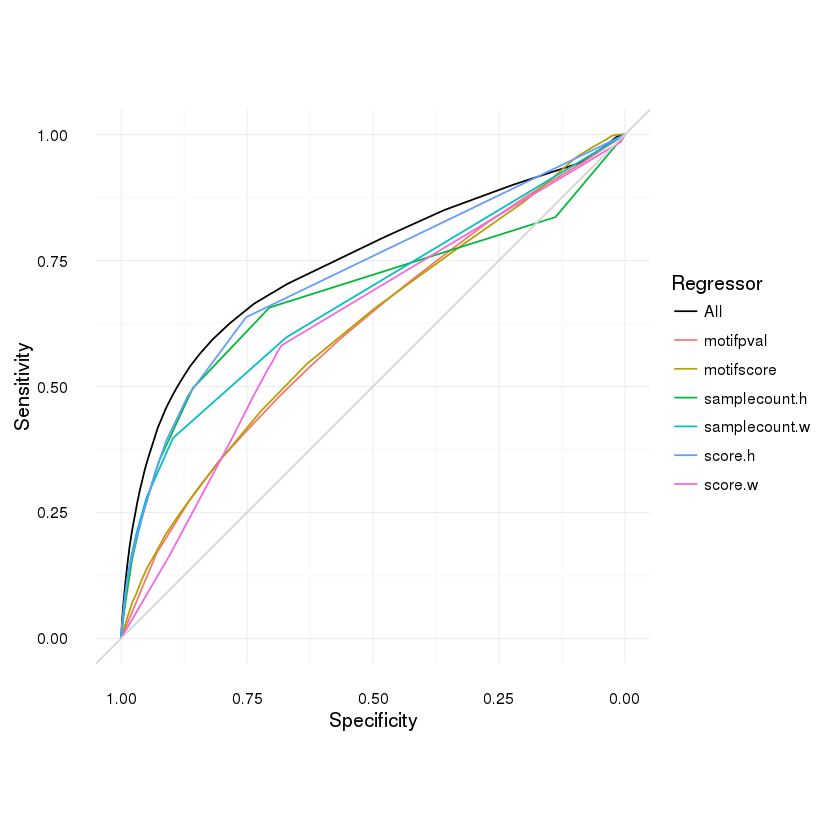

In [21]:
plot.roc.curve(foo)

Warning message:
“Removed 168 rows containing missing values (geom_path).”

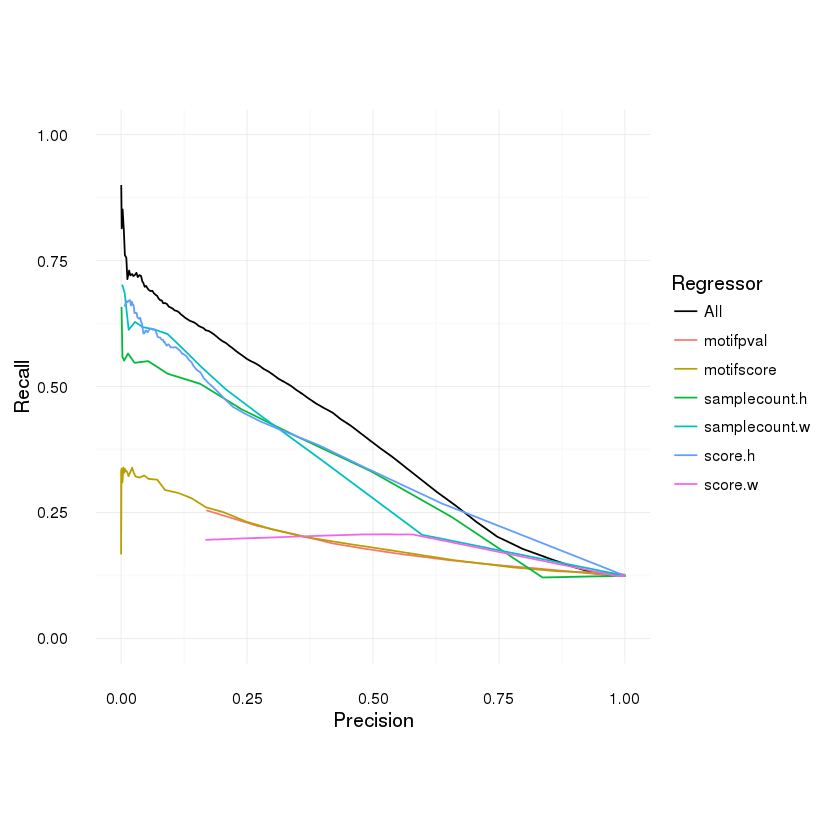

In [22]:
plot.precrecall.curve(foo)

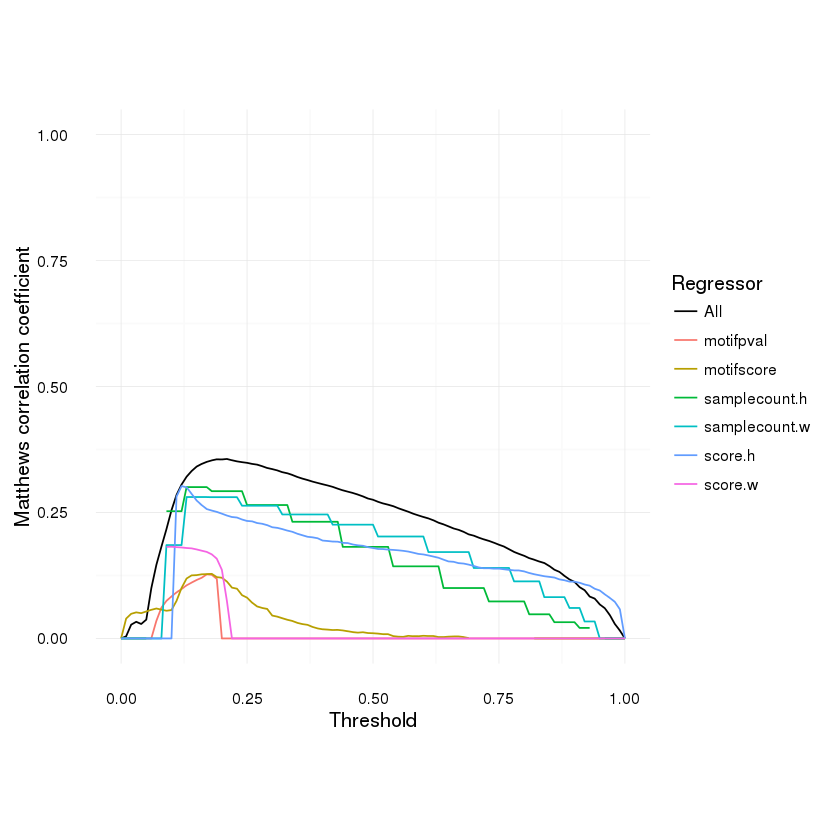

In [23]:
plot.mattcc.curve(foo)